# Linear regression/ Least square fits

#### To save files into netcdfs of linear regressed data

In [78]:
import pandas as pd
import numpy as np
import numpy.matlib as ml
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cmocean
import scipy.io as sio
import scipy.interpolate as sciint
from scipy.stats import norm
import scipy 
import scipy.signal as sig
import seaborn as sns
import pylab as pl
import xarray as xr
from matplotlib.animation import FuncAnimation
from matplotlib import animation
import ffmpeg
from math import radians, cos, sin, asin, sqrt,log,floor
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import FormatStrFormatter
import xlrd
import xlsxwriter
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Functions to load files

In [3]:
def get_Brink(file_fig):#,file_h): #, file_ratio):
    # Brink mode
    file = sio.loadmat(file_fig)
    z, xpl, xxx, zzz, xgr, zgr = file['z'][0,:], file['xpl'][0,:], file['xxx'][0,:], file['zzz'][0,:], file['xgr'], file['zgr']
    k, omega,epe,eke = file['wavenumber'][0][0], file['frequency'][0][0], file['epe'][0][0],file['eke'][0][0]

    # (u is cross-shore and v is alongshore in Brink.)
    p0, u0, v0, w0, r0 = file['p'], file['u'],file['v'], file['wvel'], file['rho']

    #file_rfw = sio.loadmat(file_ratio)
    #R = file_rfw['ratio_for_wave'][0][0]
    #print('ratio for wave', R)
    #print('k (rad/cm) ', k)
    #print('lambda (km) ', ((2*np.pi)/(k*100))*1E-3)
    #print('omega (rad/s) ', omega)
    #print('period (days)', ((2*np.pi)/omega)/(3600*24))
    #print('c (m/s)', (omega/(k*100)))
    scale=0.2
    w = w0.transpose() * 0.01 * scale # cms-1 to ms-1 and normalization (?)
    u = u0.transpose() * 0.01 * scale # cms-1 to ms-1 and normalization 
    v = v0.transpose() * 0.01 * scale # cms-1 to ms-1 and normalization 
    r = r0.transpose() * 1.0 * scale # mg/cm³ to kg/m³ and normalization
    p = p0.transpose() * 0.1 * scale # dyn/cm² to 0.1 Pa (or kg m-1 s-2) and normalization
    
    return(u,v,w,r,p,z,k,omega,xpl, xxx, zzz,zgr.transpose(),xgr.transpose(), epe, eke)

def loadNetCDFs(varname):
    dsw=[]
    dsn=[]
    for i in np.arange(0,8,1):
        
        if varname=='DYNVARS':
            pathn='/Volumes/Trillian/SVB/exp06_512x612x100_ORL/01_noSVB_febTS/'+ str(varname)+'noSVB'+ str(2+i)+'_'+ str(3+i) +'.nc'
            pathw='/Volumes/Trillian/SVB/exp06_512x612x100_ORL_SVB/01_SVB_febTS/'+ str(varname)+'withSVB'+ str(2+i)+'_'+ str(3+i) +'.nc'
        else:
            pathn='/Volumes/Trillian/SVB/exp06_512x612x100_ORL/01b_noSVB_febTS/'+ str(varname)+'noSVB'+ str(2+i)+'_'+ str(3+i) +'.nc'
            pathw='/Volumes/Trillian/SVB/exp06_512x612x100_ORL_SVB/01b_SVB_febTS/'+ str(varname)+'withSVB'+ str(2+i)+'_'+ str(3+i) +'.nc'
        
        dswin  = xr.open_dataset(pathw)
        dsnin = xr.open_dataset(pathn)
        
        dsw.append(dswin)
        dsn.append(dsnin)
        
    return dsw, dsn

# Plot

In [4]:
def LINREGplot(fig,lat,VALMITp,VALFITp,VALbrink,grid_Z,grid_X,dist,Z,TIME,BETAp,FITp,t,rmse):
    
    xlab='Crosshore distance [km]'
    ylab='Depth [m]'
    modes=len(VALbrink[:,1,1])
    
    fig = plt.figure(tight_layout=True)
    if modes<=4:
        gs = GridSpec(nrows=4, ncols=2, height_ratios=[1.5,1,1,1])
    elif modes<=6:
        gs = GridSpec(nrows=5, ncols=2, height_ratios=[1.5,1,1,1,1])
    elif modes<=8:
        gs = GridSpec(nrows=6, ncols=2, height_ratios=[1.5,1,1,1,1,1])        
    #depths=np.arange(75,-1,-1)
    vmin=-np.nanmax(abs(VALFITp[t,:,:]))
    vmax=np.nanmax(abs(VALFITp[t,:,:]))

    levels=np.linspace(vmin,vmax,15)

    vminb=-np.nanmax(abs(VALbrink))
    vmaxb=np.nanmax(abs(VALbrink))

    levelsb=np.linspace(vminb,vmaxb,15)
    

    vminr=-np.nanmax(abs(VALMITp[t,:,:]-VALFITp[t,:,:] ))
    vmaxr=np.nanmax(abs(VALMITp[t,:,:]-VALFITp[t,:,:] ))

    levelsr=np.linspace(vminr,vmaxr,15)
    
    ax6 = fig.add_subplot(gs[0, :])
    ax6.set_facecolor('tan')
    cax3=ax6.contourf(grid_X,grid_Z,VALMITp[t,:,:]-VALFITp[t,:,:] ,cmap=cmocean.cm.delta,levels=levelsr)
    ax6.contour(grid_X,grid_Z,VALMITp[t,:,:]-VALFITp[t,:,:] , levels=[0], linewidths=2, 
                linestyles='-', colors='k', zorder=2)
    ax6.set(xlabel=xlab, ylabel=ylab)
    ax6.set_title('Residuals') 

    ax0 = fig.add_subplot(gs[1, 0])
    ax0.set_facecolor('tan')
    cax1=ax0.contourf(grid_X,grid_Z,VALFITp[t,:,:] ,cmap=cmocean.cm.delta,levels=levels)
    ax0.contour(grid_X,grid_Z,VALFITp[t,:,:] , levels=[0], linewidths=2, 
                linestyles='-', colors='k', zorder=2)
    ax0.set(xlabel=xlab, ylabel=ylab)
    ax0.set_title('Linear regression fit')
   
    
    ax1 = fig.add_subplot(gs[1, 1])
    ax1.set_facecolor('tan')
    ax1.contourf(grid_X,grid_Z,VALMITp[t,:,:] ,cmap=cmocean.cm.delta,levels=levels)
    ax1.contour(grid_X,grid_Z,VALMITp[t,:,:] , levels=[0], linewidths=2, 
                linestyles='-', colors='k', zorder=2)
    ax1.set(xlabel=xlab, ylabel=ylab)
    ax1.set_title('MITgcm')
    
    for i in np.arange(0,modes,1):
        if i<=1:
            ax = fig.add_subplot(gs[2, i])
        elif i<=3:
            ax = fig.add_subplot(gs[3, i-2])
        elif i<=5:
            ax = fig.add_subplot(gs[4, i-4])
        elif i<=7:
            ax = fig.add_subplot(gs[5, i-6])
        cax2=plotbrink(ax,grid_X,grid_Z,levelsb,xlab,ylab,i,VALbrink[i])
    
    

    cbar_ax = fig.add_axes([1, 0.56, 0.03, 0.14])
    fig.colorbar(cax1, cax=cbar_ax)
    cbar_ax.set_ylabel('Pressure')
    cbar_ax.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
    
    cbar_ax2 = fig.add_axes([1, 0.08, 0.03, 0.4])
    fig.colorbar(cax2, cax=cbar_ax2)
    cbar_ax2.set_ylabel('Pressure')
    cbar_ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
    
    cbar_ax3 = fig.add_axes([1, 0.75, 0.03, 0.175])
    fig.colorbar(cax3, cax=cbar_ax3)
    cbar_ax3.set_ylabel('Residuals')
    cbar_ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
    
    if np.isnan(VALMITp[t]).any()==True:
        val=VALMITp[t]
        valf=VALFITp[t]
        std=np.std(val[~np.isnan(val)]-valf[~np.isnan(val)])
    else:
        std=np.std(VALMITp[t,:,:]-VALFITp[t,:,:])
    func=f'Regression line: Y = {BETAp[t,0]:.2e}'
    for i in np.arange(len(BETAp[t])-1):
            func += f'+ {BETAp[t,i+1]:.2e}X {i+1}'
    fig.suptitle(func + f'\n At {lat}°N. After {TIME[t]/(60*24):.1f} days. STD: {std:.2e}. RMSE:{rmse:.3e} ')
    #fig.tight_layout()

def plotbrink(ax,grid_X,grid_Z,levelsb,xlab,ylab,nr,varbrink):
    ax.set_facecolor('tan')
    cax=ax.contourf(grid_X,grid_Z,varbrink ,cmap=cmocean.cm.delta,levels=levelsb)
    ax.contour(grid_X,grid_Z,varbrink , levels=[0], linewidths=2, 
                linestyles='-', colors='k', zorder=2)
    ax.set(xlabel=xlab, ylabel=ylab)
    ax.set_title(f'Brink mode {nr+1}')
    
    return cax

## Showing the different CTW modes and their stats

In [106]:
u,v0,w0,r,p0,z,k0,omega0,xpl, xxx, zzz, zgr, xgr, epe0, eke0= get_Brink('Crossects/dataSVB31.4mode0.mat')
u,v1,w1,r,p1,z,k1,omega1,xpl, xxx, zzz, zgr, xgr, epe1, eke1= get_Brink('Crossects/dataSVB31.4mode1.mat')
u,v2,w2,r,p2,z,k2,omega2,xpl, xxx, zzz, zgr, xgr, epe2, eke2= get_Brink('Crossects/dataSVB31.4mode2.mat')
u,v3,w3,r,p3,z,k3,omega3,xpl, xxx, zzz, zgr, xgr, epe3, eke3= get_Brink('Crossects/dataSVB31.4mode3.mat')
u,v4,w4,r,p4,z,k4,omega4,xpl, xxx, zzz, zgr, xgr, epe4, eke4= get_Brink('Crossects/dataSVB31.4mode4.mat')
u,v5,w5,r,p5,z,k5,omega5,xpl, xxx, zzz, zgr, xgr, epe5, eke5= get_Brink('Crossects/dataSVB31.4mode5.mat')
#u,v6,w6,r,p6,z,k6,omega6,xpl, xxx, zzz, zgr, xgr, epe6, eke6= get_Brink('Crossects/dataSVB30mode9.mat')

In [54]:
params = {'font.size': 26,
          'figure.figsize': (20, 20),
         'font.family':'serif'}
pl.rcParams.update(params)

In [107]:
vals=np.array([p0, p1, p2, p3, p4,p5])
eke=np.array([eke0, eke1, eke2, eke3, eke4,eke5])
epe=np.array([epe0, epe1,epe2, epe3, epe4,epe5])
omega=np.array([omega0, omega1,omega2, omega3, omega4,omega5])
k=np.array([k0, k1,k2, k3, k4,k5])

In [68]:
vals=np.array([p0, p1, p2, p3, p4])
eke=np.array([eke0, eke1, eke2, eke3, eke4])
epe=np.array([epe0, epe1,epe2, epe3, epe4])
omega=np.array([omega0, omega1,omega2, omega3, omega4])
k=np.array([k0, k1,k2, k3, k4])

period (days) [  0.91575747   1.77515819   2.71078756   2.4689572  199.59068317
   2.22632895   6.66666667]
c (m/s) [8.7359375  2.02798828 1.03291016 0.64804687 0.60123047 0.35933594
 0.15      ]
R=EKE/EPE [3.59368555e+04 1.81348047e+00 2.26573358e+00 2.79253038e+00
 1.99705146e+00 1.54402693e+00 1.59853551e+00]
[7.94119128e-05 4.09665193e-05 2.68269094e-05 2.94545617e-05
 3.64355946e-07 3.26645585e-05 1.09083078e-05]
[9.09025652e-08 2.02005700e-07 2.59721615e-07 4.54512826e-07
 6.06017101e-09 9.09025652e-07 7.27220522e-07]
[  691.2    311.04   241.92   138.24 10368.      69.12    86.4 ]


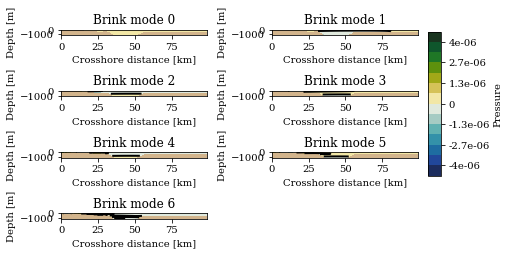

In [83]:
vals=np.array([p0, p1, p2, p3, p4,p5,p6])
eke=np.array([eke0, eke1, eke2, eke3, eke4,eke5,eke6])
epe=np.array([epe0, epe1,epe2, epe3, epe4,epe5,epe6])
omega=np.array([omega0, omega1,omega2, omega3, omega4,omega5,omega6])
k=np.array([k0, k1,k2, k3, k4,k5,k6])

vminb=-np.nanmax(abs(vals))
vmaxb=np.nanmax(abs(vals))

levelsb=np.linspace(vminb,vmaxb,15)

xlab='Crosshore distance [km]'
ylab='Depth [m]'
modes=len(vals[:,1,1])
    
fig = plt.figure(tight_layout=True)
if modes<=4:
    gs = GridSpec(nrows=3, ncols=2, height_ratios=[1,1,1])
elif modes<=6:
    gs = GridSpec(nrows=4, ncols=2, height_ratios=[1,1,1,1])
elif modes<=8:
    gs = GridSpec(nrows=5, ncols=2, height_ratios=[1,1,1,1,1])
    
for i in np.arange(-1,modes-1,1):
        if i<=0:
            ax = fig.add_subplot(gs[0, i+1])
        elif i<=2:
            ax = fig.add_subplot(gs[1, i-1])
        elif i<=4:
            ax = fig.add_subplot(gs[2, i-3])
        elif i<=6:
            ax = fig.add_subplot(gs[3, i-5])
        cax2=plotbrink(ax,xgr,zgr,levelsb,xlab,ylab,i,vals[i+1])

cbar_ax2 = fig.add_axes([1, 0.4, 0.03, 0.5])
fig.colorbar(cax2, cax=cbar_ax2)
cbar_ax2.set_ylabel('Pressure')
cbar_ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
        
print(f'period (days) {(2*np.pi)/omega/(3600*24)}')
print(f'c (m/s) {omega/(k*100)}')
print(f'R=EKE/EPE {(eke/epe)}')
print(omega)
print(k)
print((omega/(k*100))*((2*np.pi)/omega)/1000)

In [108]:
P=(2*np.pi)/omega/(3600*24)
C=omega/(k*100)
R=(eke/epe)
WL=(omega/(k*100))*((2*np.pi)/omega)/1000

In [92]:
# Create a workbook and add a worksheet.
workbook = xlsxwriter.Workbook('Crossects/Table1.xlsx')
worksheet = workbook.add_worksheet()

In [109]:
# Some data we want to write to the worksheet.
expenses = (
    ['Wavenumber (rad/cm) ', k],
    ['Wavelength (km) ',   WL],
    ['Angular frequency (rad/s)',  omega],
    ['Period (days) ',    P],
    ['Phase speed (m/s)  ',    C],
)

# Start from the first cell. Rows and columns are zero indexed.
row0 = 16
row=row0
col = 0
worksheet.write(row-2, 0,     '31.40°N')
# Iterate over the data and write it out row by row.
for item, cost in (expenses):
    col=0
    worksheet.write(row, col,     item)
    for i in np.arange(0,len(cost),1):
        worksheet.write(row0-1, col+ 1, f'Mode {i}')
        worksheet.write(row, col+ 1, cost[i])
        col+=1
    row += 1



In [110]:
workbook.close()

## Loading the data

In [6]:
ds3084=xr.open_dataset('Crossects/LinReg3084FILT.nc') 
ds312=xr.open_dataset('Crossects/LinReg312FILT.nc')
ds3268=xr.open_dataset('Crossects/LinReg3268FILT.nc')
ds3298=xr.open_dataset('Crossects/LinReg3298FILT.nc')

In [7]:
def LoadLinReg(ds):
    VALFIT=ds.valfit.values
    VALMIT=ds.valmit.values
    VALBRINK=ds.varbrink.values
    FIT=ds.fit.values
    grid_Z=ds.gridZ.values
    grid_X=ds.gridX.values
    BETA=ds.betas.values
    RMSE=ds.rmse.values
    dist=ds.x.values
    Z=ds.z.values
    TIME=ds.time.values
    
    return VALFIT, VALMIT, VALBRINK, FIT, grid_Z, grid_X, BETA, RMSE, dist, Z, TIME

In [10]:
varname='WVEL'
i=1
pathn='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL/01_noSVB_febTS/'+ str(varname)+'ACnoSVBdep55'+ str(2+i)+'_'+ str(3+i) +'all.nc'
ds1  = xr.open_dataset(pathn)
lon_ac=ds1.lonAC
lat_ac=ds1.latAC

## Visualising the fit

In [11]:
params = {'font.size': 26,
          'figure.figsize': (20, 30),
         'font.family':'sans'}
pl.rcParams.update(params)

## 30.84 °N 

In [11]:
VALFIT3084, VALMIT3084, VALBRINK3084, FIT3084, grid_Z3084, grid_X3084, BETA3084, RMSE3084, \
dist3084, Z3084, TIME3084 =LoadLinReg(ds3084)

<Figure size 1440x2160 with 0 Axes>

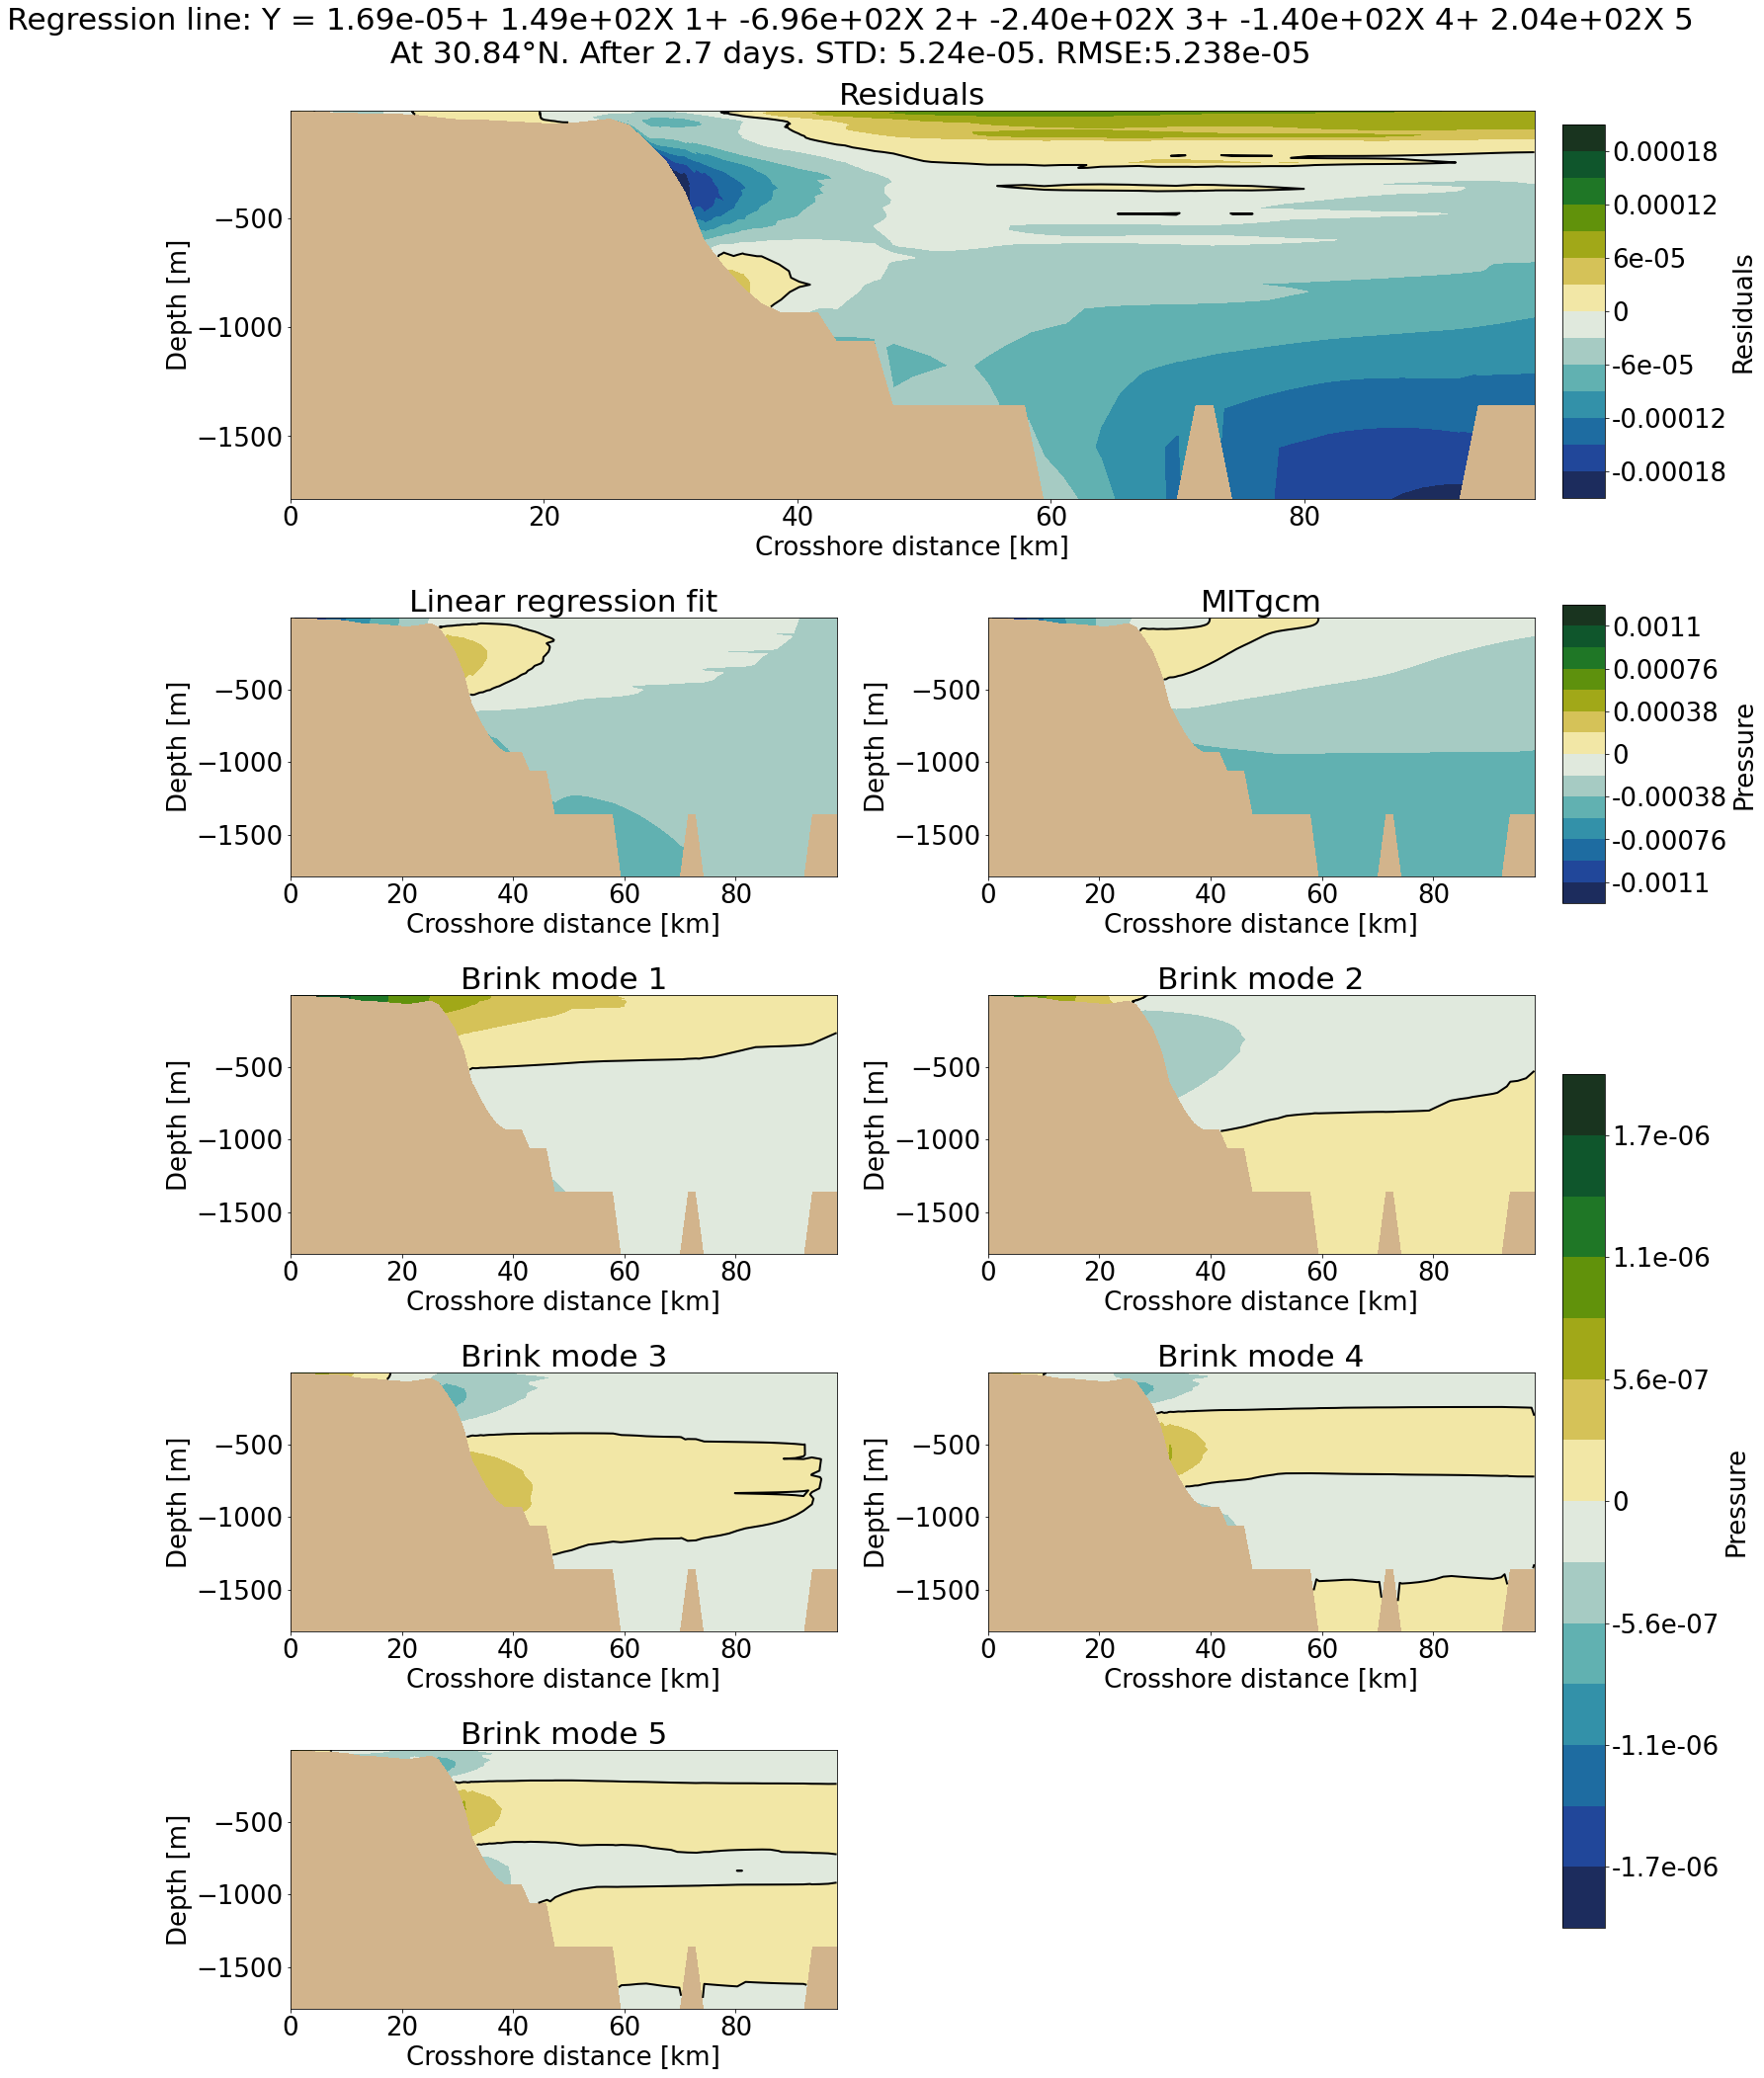

In [13]:
ind=lat_ac[58] # [58, 85, 205, 227] use one of these indices to create pressure plots in order: 30.84,31.20,32.68,32.98°N
lat=30.84
t=50
fig = plt.figure()
LINREGplot(fig,lat,VALMIT3084,VALFIT3084,VALBRINK3084,
           grid_Z3084,grid_X3084,dist3084,Z3084,TIME3084,BETA3084,FIT3084,t,RMSE3084[t])

## 31.20 °N 

In [12]:
VALFIT312, VALMIT312, VALBRINK312, FIT312, grid_Z312, grid_X312, BETA312, RMSE312,  \
dist312, Z312, TIME312 =LoadLinReg(ds312)

<Figure size 1440x2160 with 0 Axes>

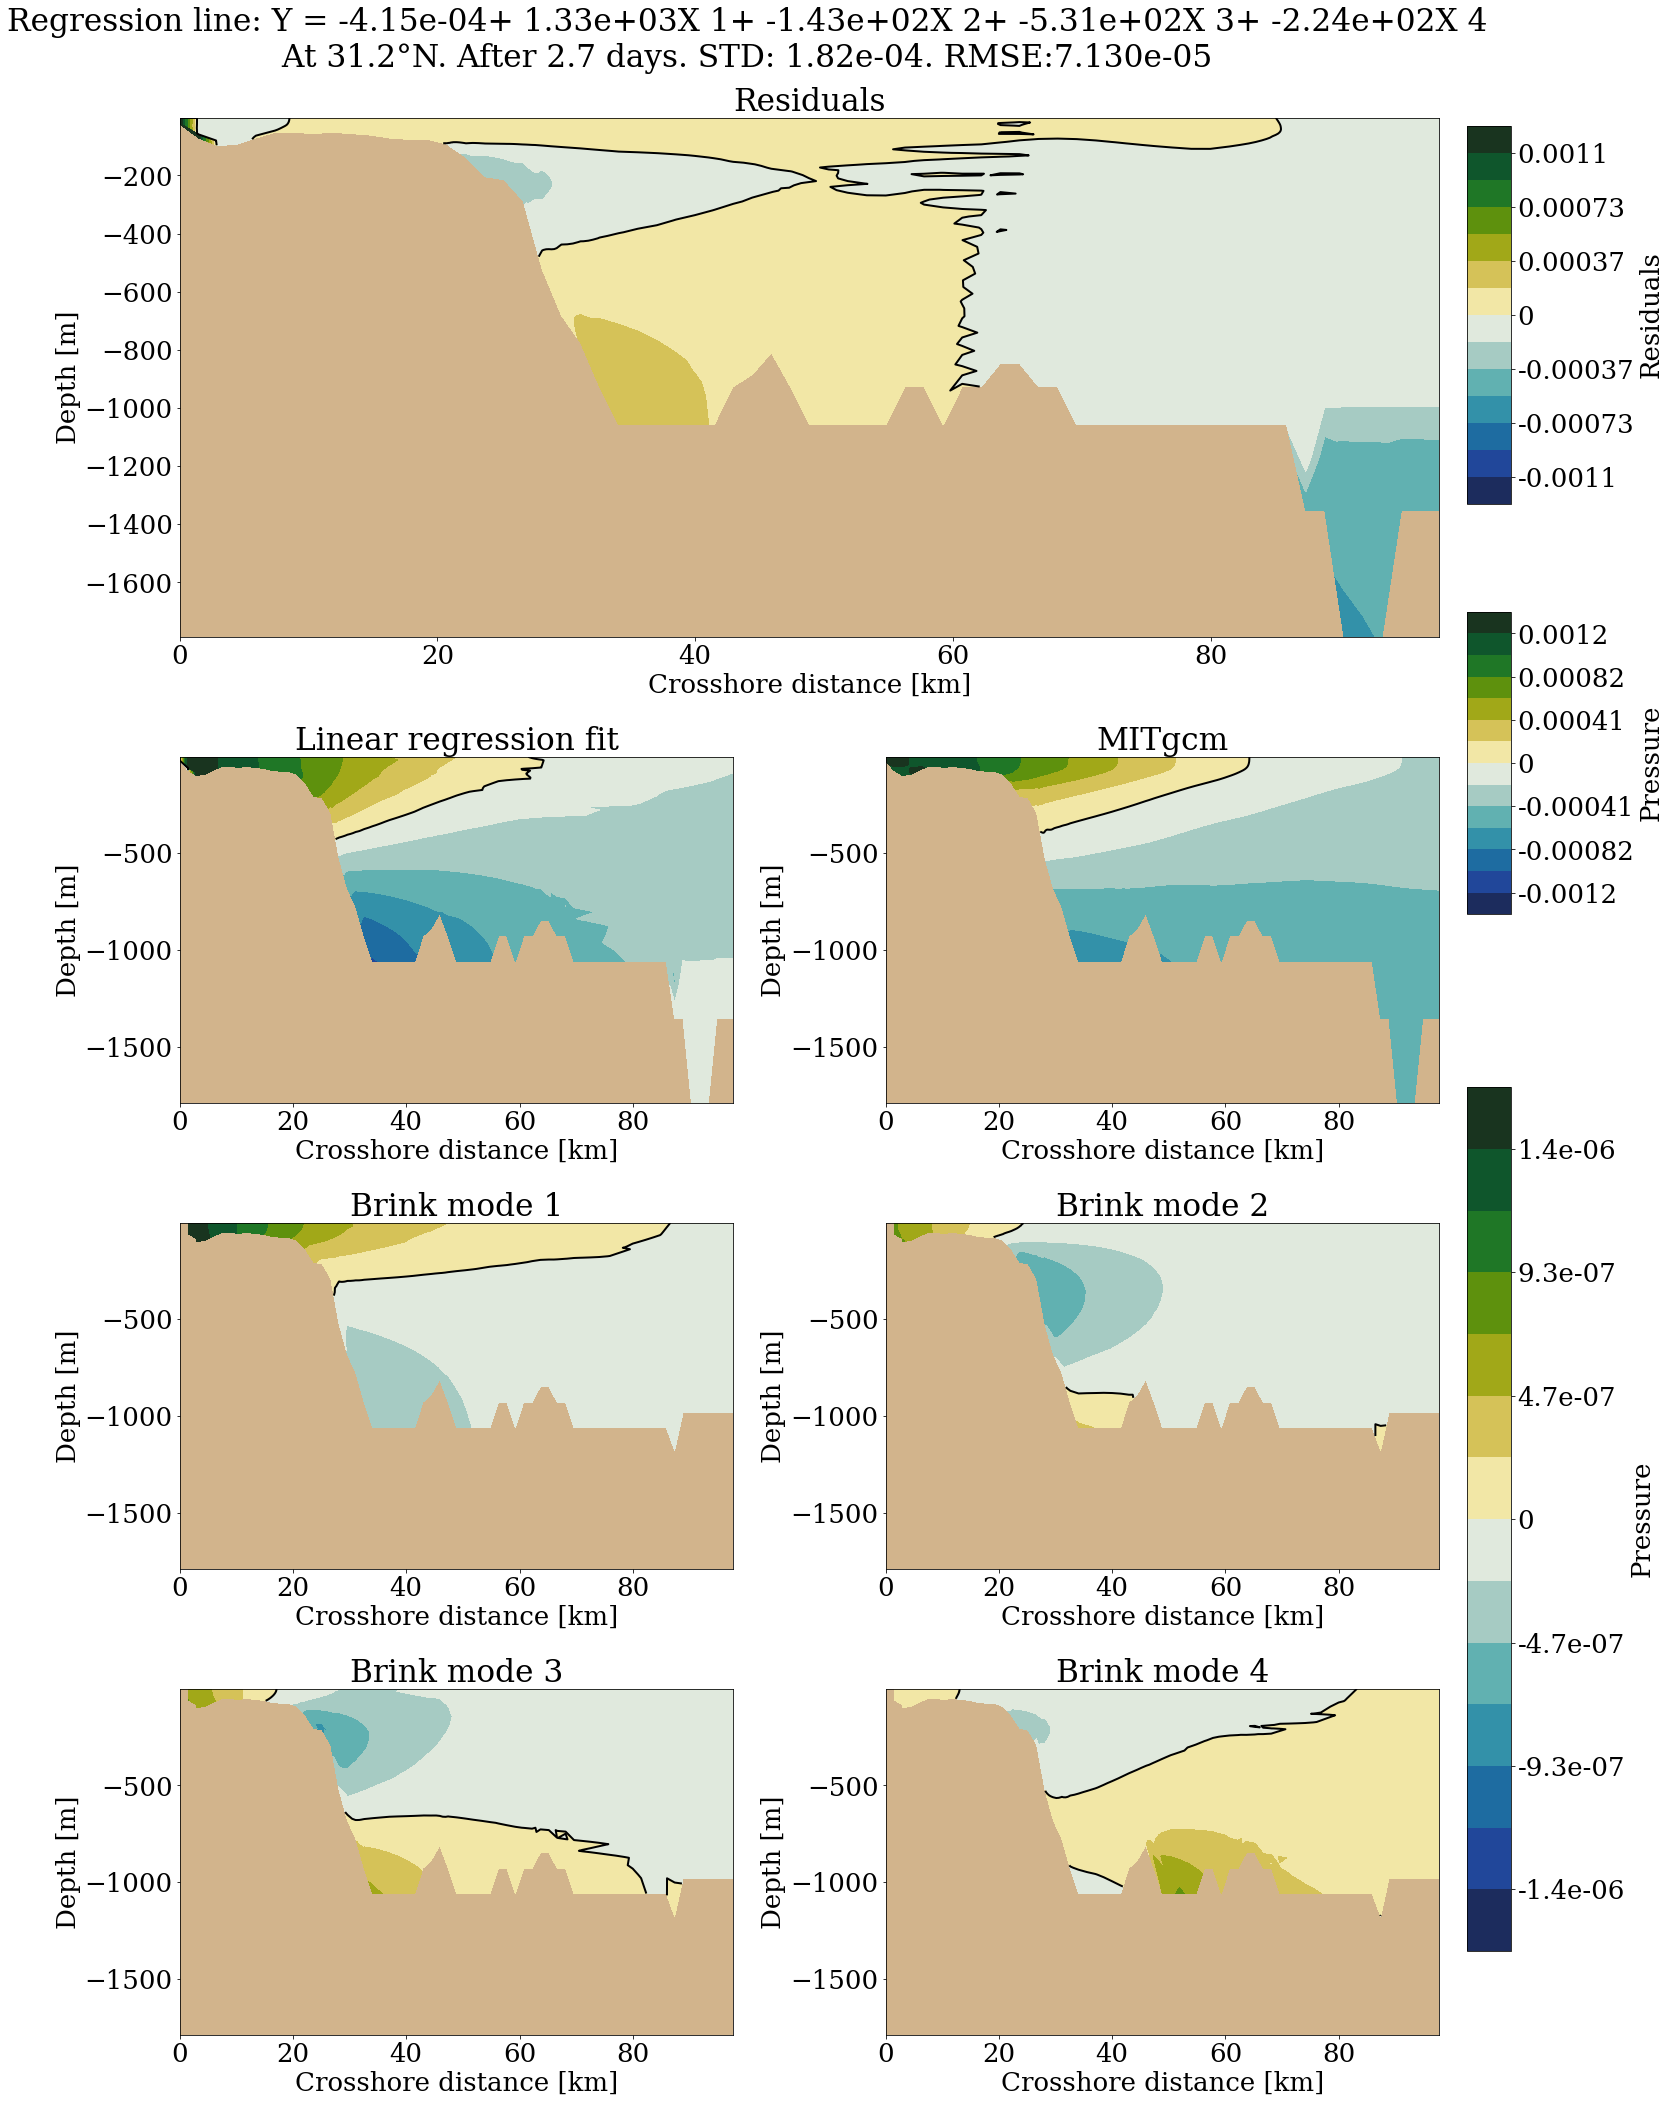

In [14]:
t=50
lat=31.20
fig = plt.figure()
LINREGplot(fig,lat,VALMIT312,VALFIT312,VALBRINK312,
           grid_Z312,grid_X312,dist312,Z312,TIME312,BETA312,FIT312,t,RMSE312[t])

## 32.68 °N 

In [13]:
VALFIT3268, VALMIT3268, VALBRINK3268, FIT3268, grid_Z3268, grid_X3268, BETA3268, RMSE3268,  \
dist3268, Z3268, TIME3268 =LoadLinReg(ds3268)

<Figure size 1440x2160 with 0 Axes>

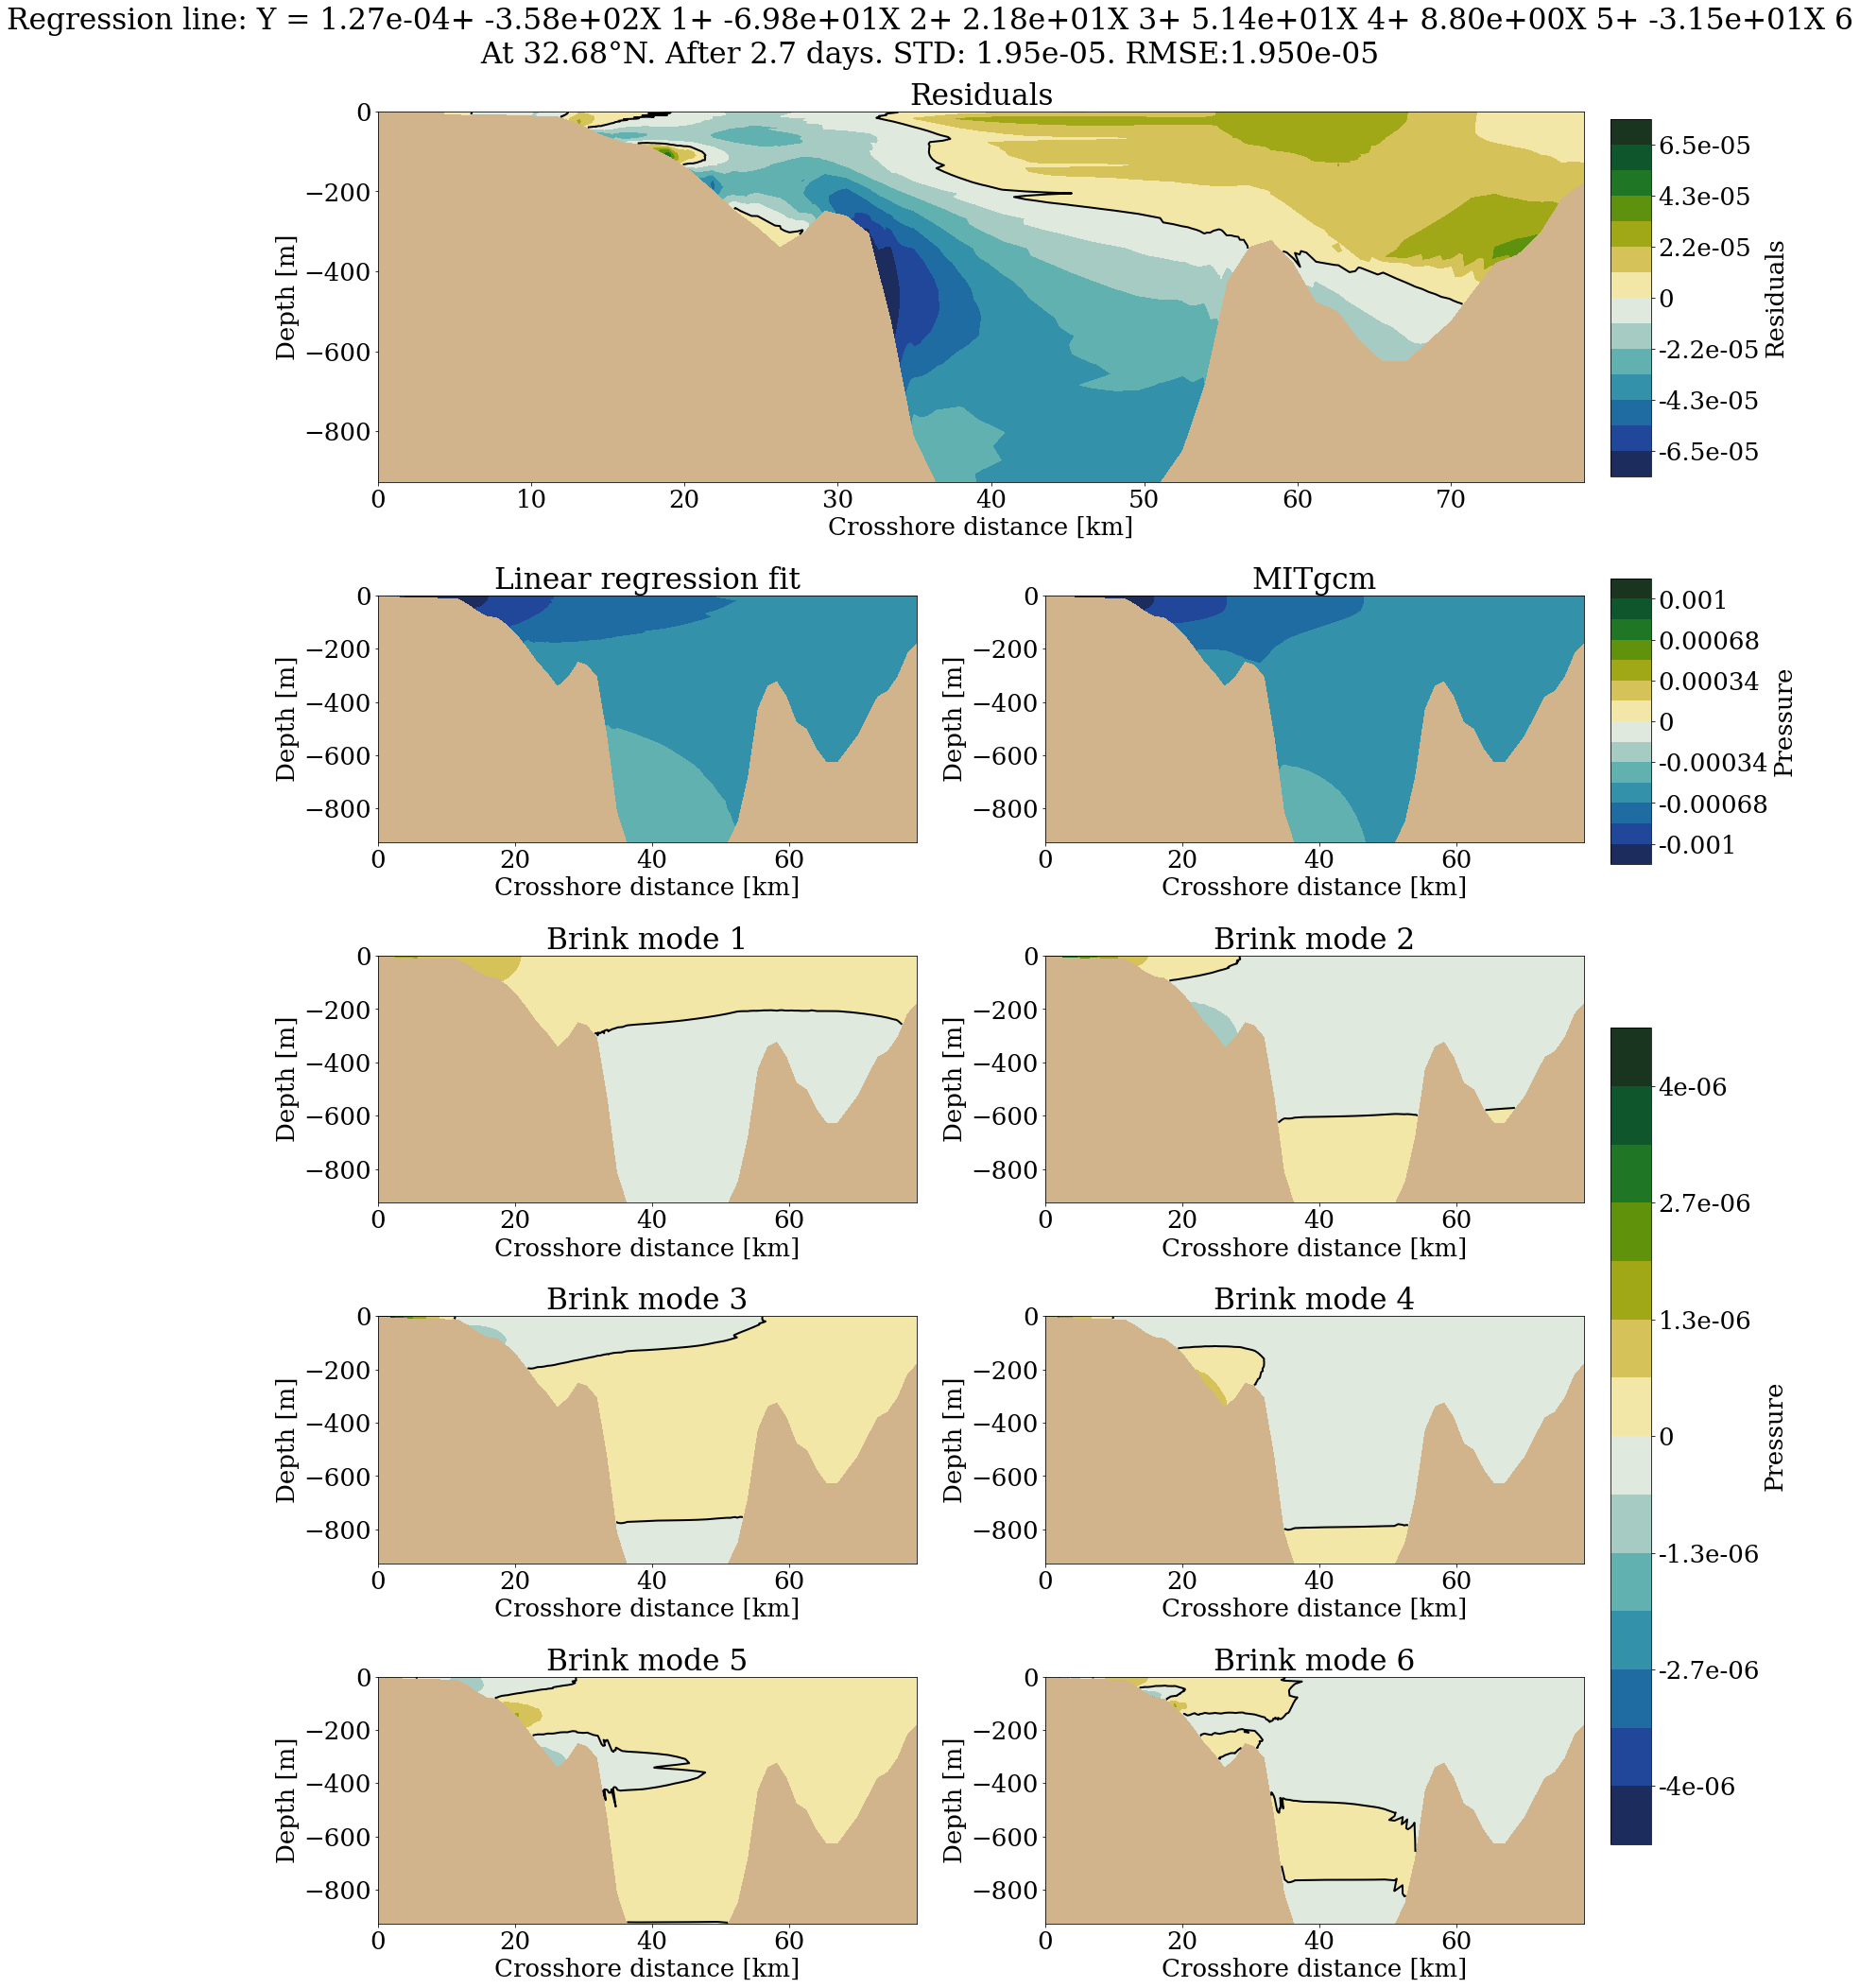

In [16]:
t=50
lat=32.68
fig = plt.figure()
LINREGplot(fig,lat,VALMIT3268,VALFIT3268,VALBRINK3268,
           grid_Z3268,grid_X3268,dist3268,Z3268,TIME3268,BETA3268,FIT3268,t,RMSE3268[t])

## 32.98 °N 

In [14]:
VALFIT3298, VALMIT3298, VALBRINK3298, FIT3298, grid_Z3298, grid_X3298,BETA3298, RMSE3298, \
dist3298, Z3298, TIME3298 =LoadLinReg(ds3298)

<Figure size 1440x2160 with 0 Axes>

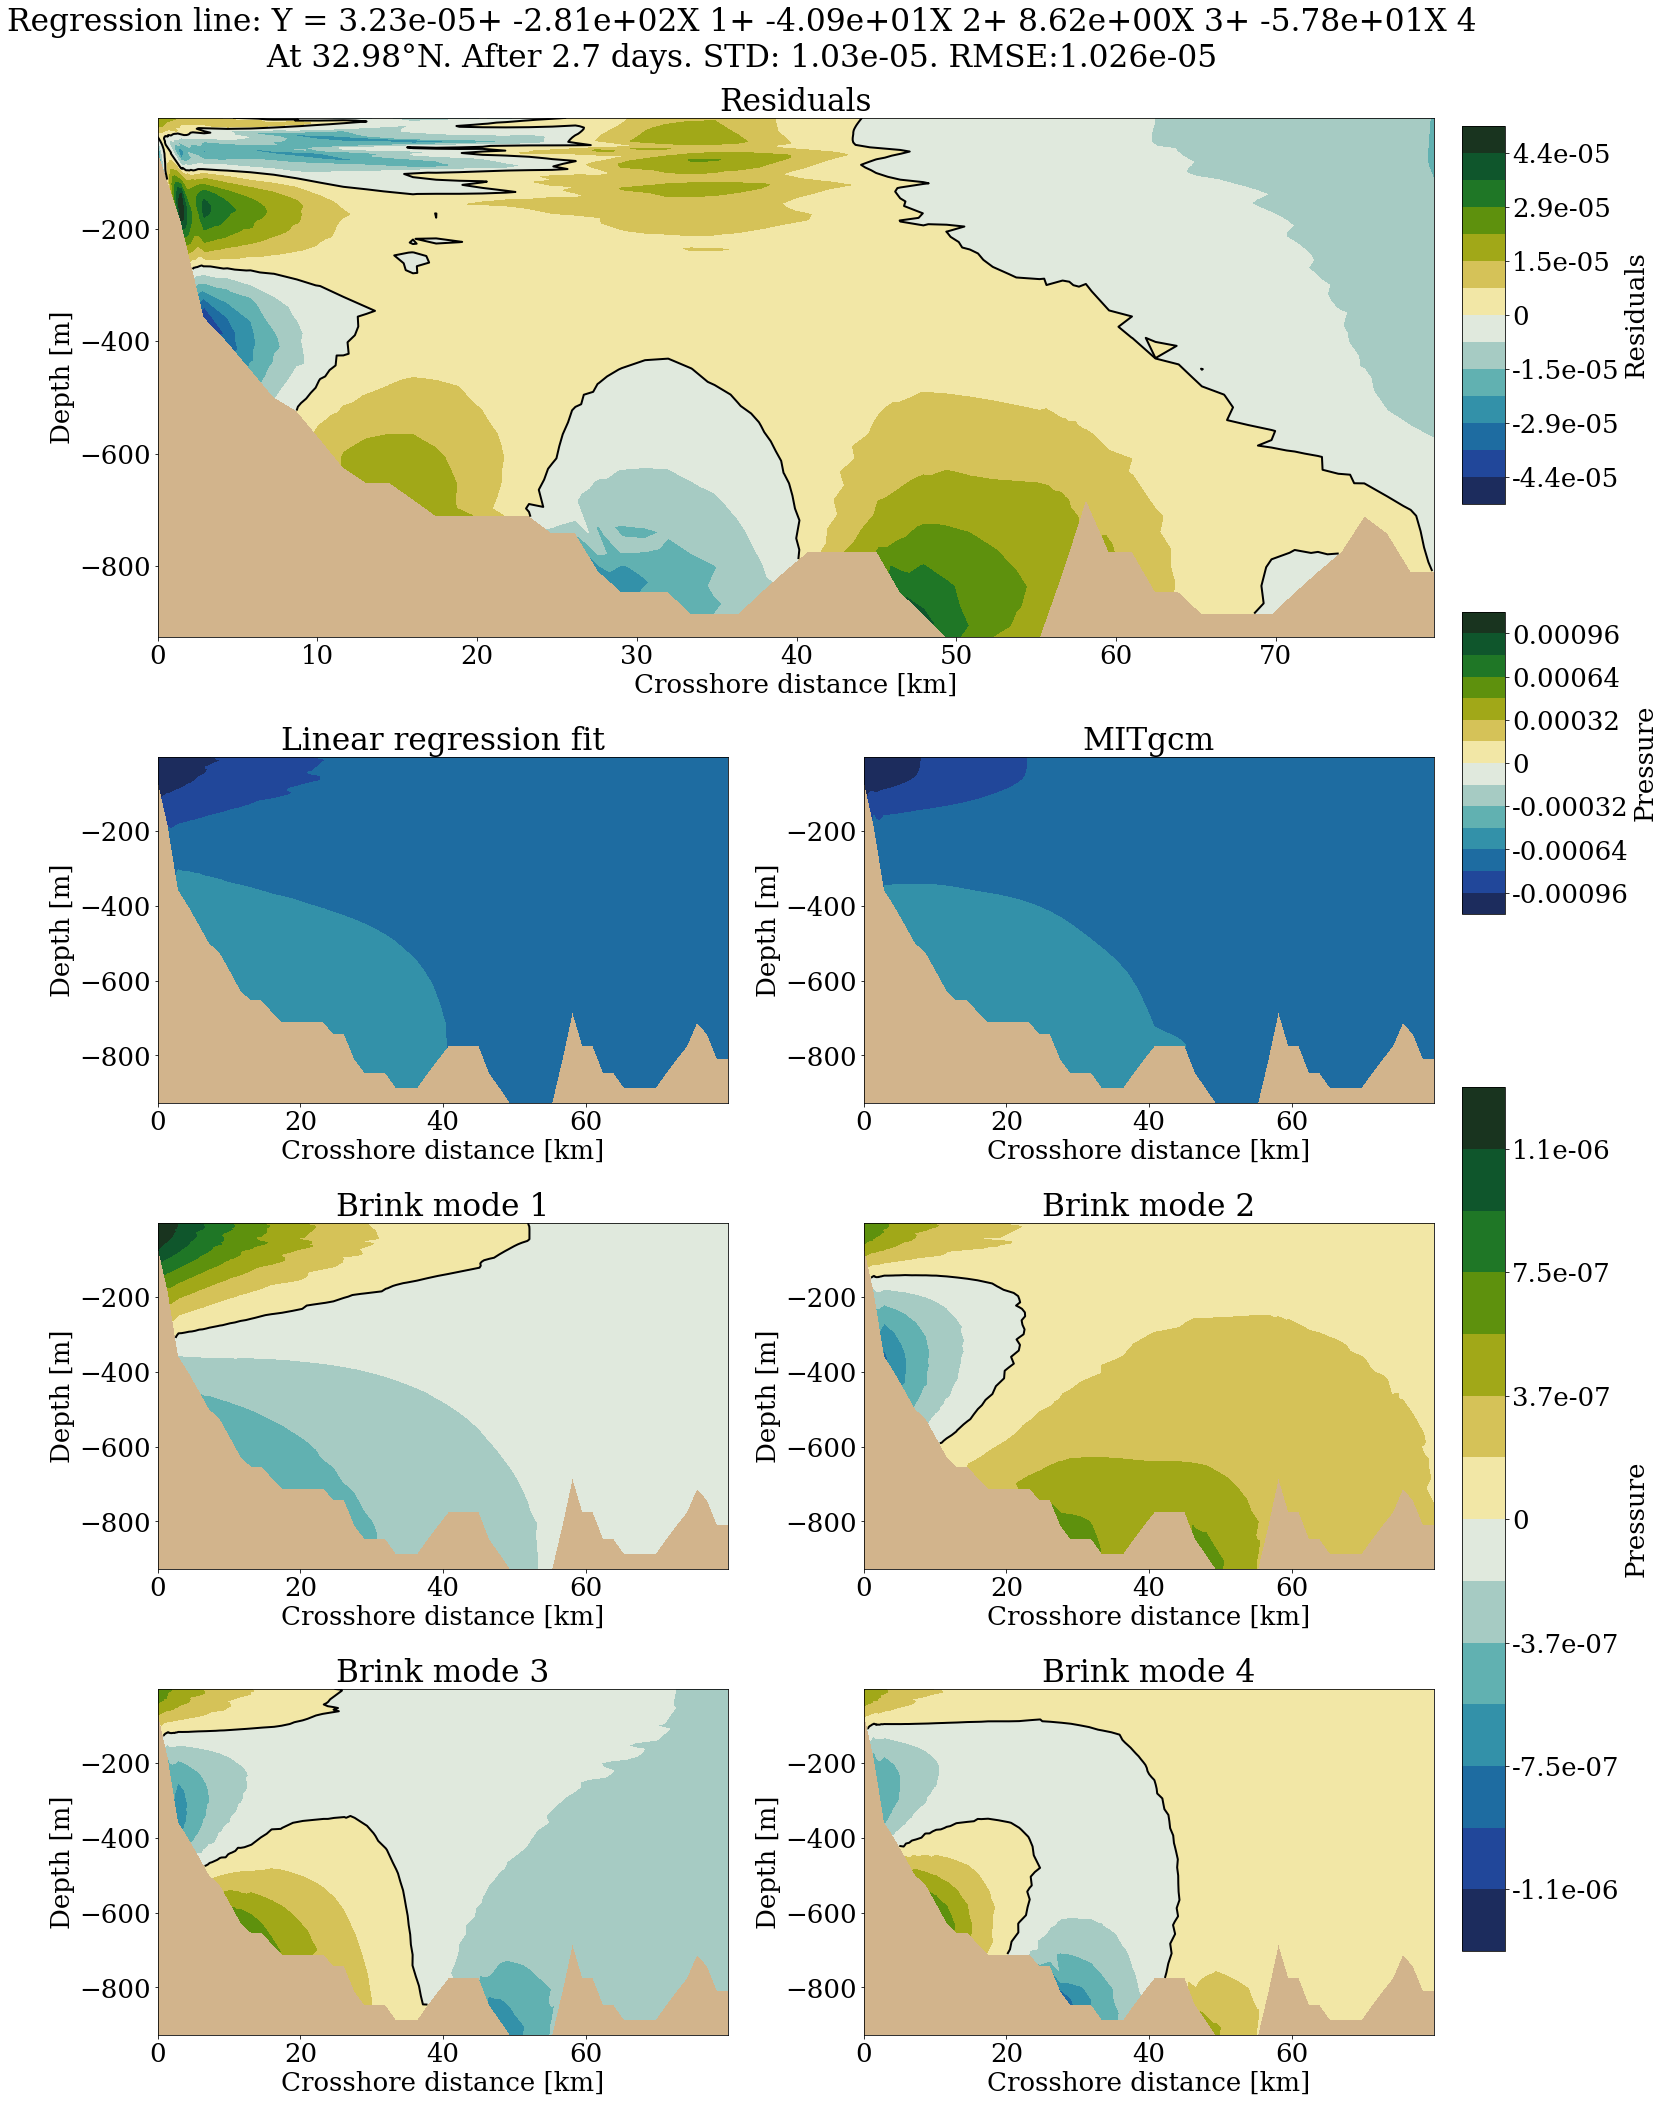

In [18]:
t=50
lat=32.98
fig = plt.figure()
LINREGplot(fig,lat,VALMIT3298,VALFIT3298,VALBRINK3298,
           grid_Z3298,grid_X3298,dist3298,Z3298,TIME3298,BETA3298,FIT3298,t,RMSE3298[t])

In [15]:
params = {'font.size': 16,
          'figure.figsize': (10, 10),
         'font.family':'sans'}
pl.rcParams.update(params)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [16]:
betas=[BETA3084,BETA312]
betas2=[BETA3268,BETA3298]

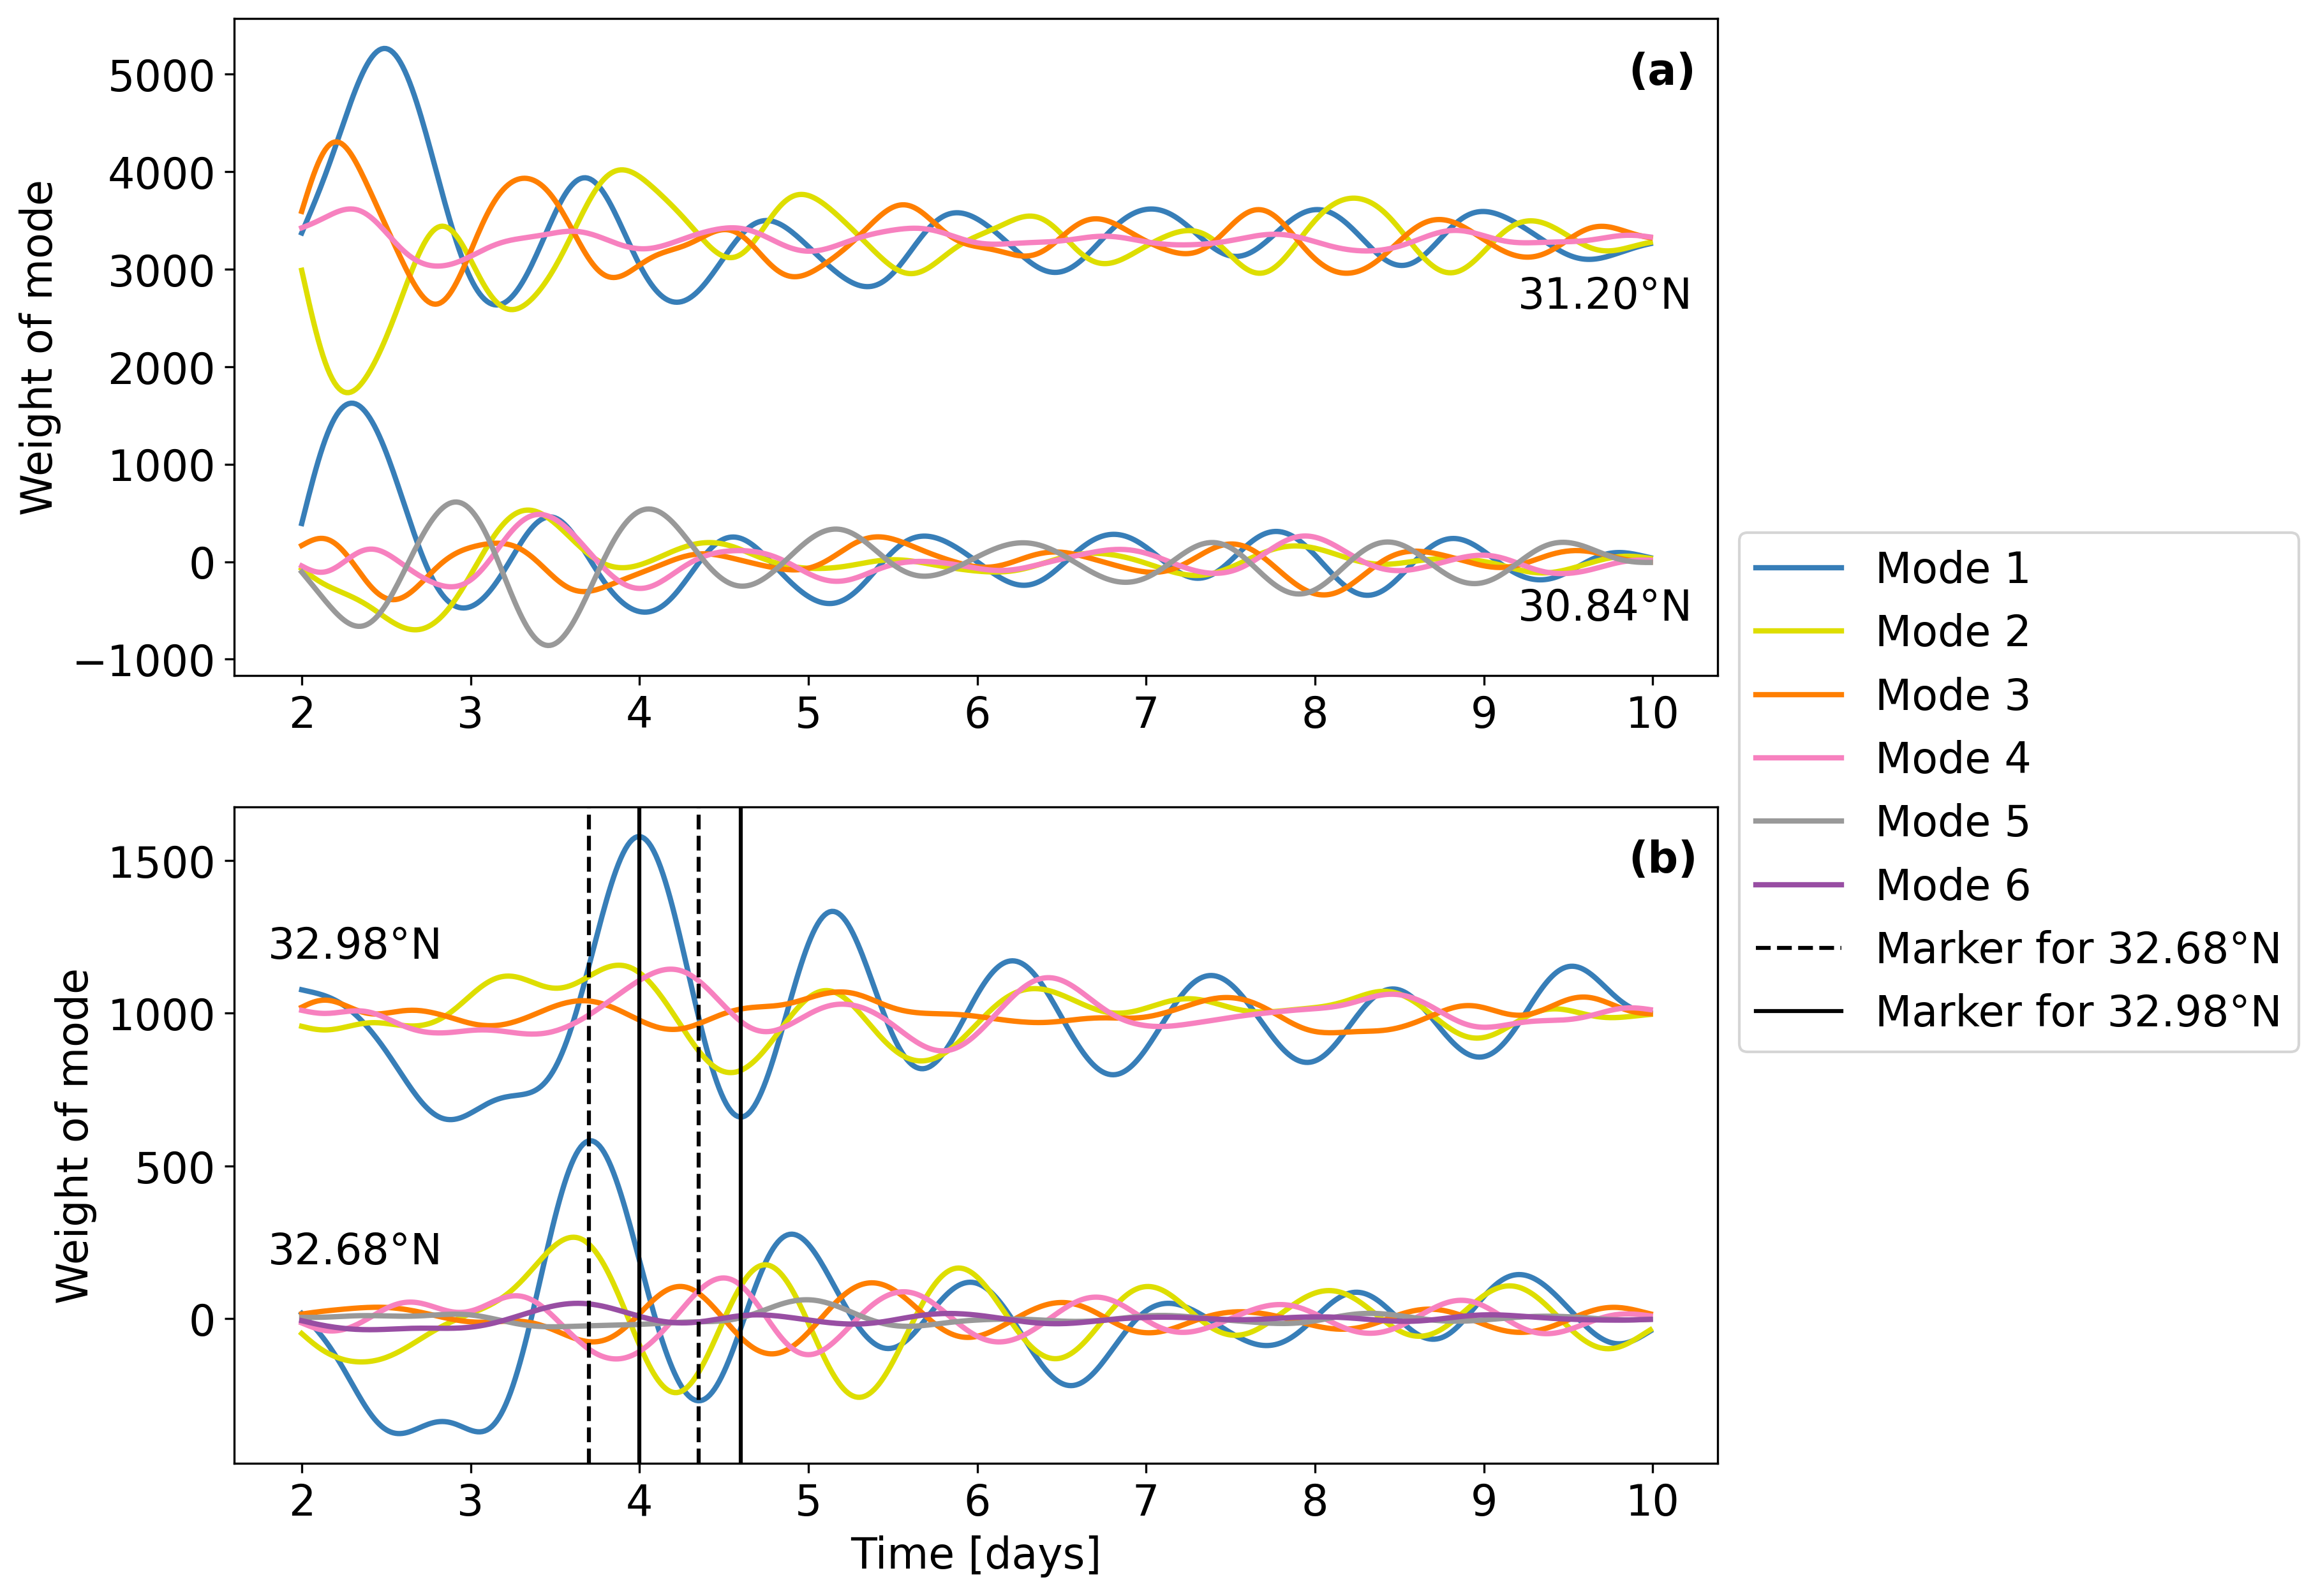

In [64]:
xlab='Time [days]'
ylab='Weight of mode'

colors=['#377eb8','#dede00','#ff7f00','#f781bf','#999999','#984ea3']
fig,ax=plt.subplots(2)
for i in np.arange(1,7,1):
    for l in np.arange(0,2,1):
        
        if l==0:
            if len(betas[l][0,:])>i:
                ax[0].plot(TIME312/(60*24),betas[l][:,i], color=colors[i-1],label=f'Mode {i}', linewidth=2)
            if len(betas2[l][0,:])>i:
                ax[1].plot(TIME312/(60*24),betas2[l][:,i], color=colors[i-1], label=f'Mode {i}',linewidth=2)
        else:
            if len(betas[l][0,:])>i:
                ax[0].plot(TIME312/(60*24),betas[l][:,i]+l*3300, color=colors[i-1], linewidth=2)
            if len(betas2[l][0,:])>i:
                ax[1].plot(TIME312/(60*24),betas2[l][:,i]+l*1000, color=colors[i-1], linewidth=2)

#plt.set(xlabel='Time (hrs)', ylabel='Mode nr')
#ax[0].legend()
ax[0].annotate('30.84°N', (9.2,-600))
ax[0].annotate('31.20°N', (9.2,2600))
ax[0].set( ylabel=ylab)
ax[0].text(0.94, 0.9, '(a)', fontweight='bold', color='k', 
            transform=ax[0].transAxes)

#ax[0].legend(bbox_to_anchor=(1.25, 0.2))
ax[1].annotate('32.68°N', (1.8,180))
ax[1].annotate('32.98°N', (1.8,1180))
ax[1].text(0.94, 0.9, '(b)', fontweight='bold', color='k', 
            transform=ax[1].transAxes)
ax[1].set(xlabel=xlab, ylabel=ylab)

ax[1].axvline(x = 4.35, color = 'k',linestyle='dashed')
ax[1].axvline(x = 3.7, color = 'k',linestyle='dashed', label = 'Marker for 32.68°N')

ax[1].axvline(x = 4.6, color = 'k')
ax[1].axvline(x = 4, color = 'k', label = 'Marker for 32.98°N')
ax[1].legend(bbox_to_anchor=(1.0, 1.45))

##### 